In [1]:
import sklearn
import pandas as pd
import numpy as np

In [2]:
# Load Data
PATH = 'E:/datasets/simulator/1_1/'
raw_data = pd.read_csv(PATH + 'labels.csv', sep=r'\s*,\s*',)
raw_data = raw_data.sample(frac=1).reset_index(drop=True)

# Preprocess
data = raw_data[['minX', 'minY', 'maxX', 'maxY', 'distance']]

print(data.head())
print(data.describe())

   minX  minY  maxX  maxY  distance
0   538     0   579    79   4611.40
1   360    71   387   118   6899.44
2   584     0   635    93   4035.00
3   434     0   589   295   1061.70
4   382    64   403   109   7228.72
              minX         minY         maxX         maxY     distance
count  6024.000000  6024.000000  6024.000000  6024.000000  6024.000000
mean    294.229084    89.269256   371.143426   229.050465  3578.986587
std     181.539338    86.155793   184.389915   124.589625  2200.520969
min       0.000000     0.000000     9.000000    22.000000   346.760000
25%     148.000000     1.000000   223.000000   132.000000  1566.167500
50%     298.000000    77.000000   383.000000   213.000000  3256.645000
75%     440.000000   160.000000   523.000000   298.000000  5368.387500
max     628.000000   460.000000   639.000000   479.000000  8590.180000


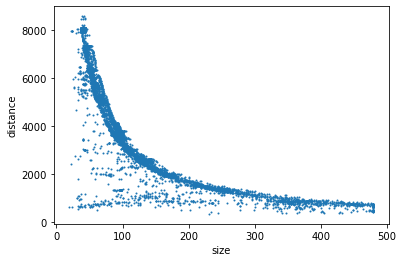

In [12]:
# Visualize
vis_data = data.copy()
vis_data['size'] = vis_data.apply(lambda row: (row.maxY - row.minY), axis=1)
vis_data.plot.scatter(y='distance', x='size', s=1)

In [13]:
# Create Training/Validation Data
X, y = data[['minX', 'minY', 'maxX', 'maxY',]], data['distance']

# Scale
X[['minX', 'maxX']] /= 640
X[['minY', 'maxY']] /= 480

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [31]:
# Train Models
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

#from sklearn.preprocessing import PolynomialFeatures
#poly = PolynomialFeatures(degree=2)
#X_ = poly.fit_transform(X_train)
#predict_ = poly.fit_transform(predict)

#clf = linear_model.LinearRegression()
#clf.fit(X_, vector)

from sklearn.ensemble import RandomForestRegressor
from sklearn import tree

forest_reg = RandomForestRegressor(random_state=42)
#forest_reg = tree.DecisionTreeRegressor(max_depth=10)
forest_reg.fit(X_train, y_train)

# (Optional) Use GridSearch for Hyperparameter Tuning
'''from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30, 50], 'max_depth': [2, 4, 6, 8, 16, 32, 64]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_estimator_)
forest_reg = grid_search.best_estimator_'''

"from sklearn.model_selection import GridSearchCV\n\nparam_grid = [\n    {'n_estimators': [3, 10, 30, 50], 'max_depth': [2, 4, 6, 8, 16, 32, 64]},\n  ]\n\nforest_reg = RandomForestRegressor(random_state=42)\n# train across 5 folds, that's a total of (12+6)*5=90 rounds of training \ngrid_search = GridSearchCV(forest_reg, param_grid, cv=5,\n                           scoring='neg_mean_squared_error',\n                           return_train_score=True)\ngrid_search.fit(X_train, y_train)\nprint(grid_search.best_params_)\nprint(grid_search.best_estimator_)\nforest_reg = grid_search.best_estimator_"

In [32]:
# Evaluate Models
from sklearn.metrics import mean_squared_error

def evaluate(predictor):
    print(type(predictor))
    pred = predictor.predict(X_train)
    mse = mean_squared_error(y_train, pred)
    rmse = np.sqrt(mse)
    print('Train: ', rmse)
    pred = predictor.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    print('Test: ', rmse)

evaluate(lin_reg)
evaluate(forest_reg)

<class 'sklearn.linear_model._base.LinearRegression'>
Train:  1344.3420096788968
Test:  1339.3269326615773
<class 'sklearn.ensemble._forest.RandomForestRegressor'>
Train:  158.24704529511743
Test:  416.9474584772528


In [33]:
# Save best Model
from joblib import dump, load
dump(forest_reg, 'distance_predictor.joblib')

['distance_predictor.joblib']

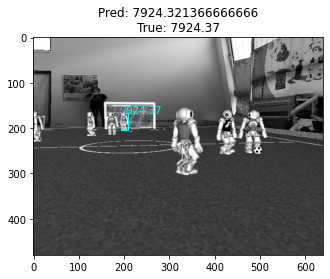

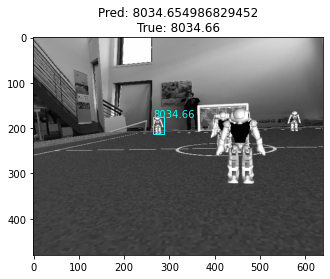

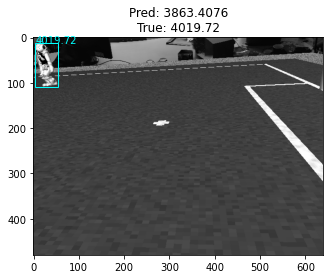

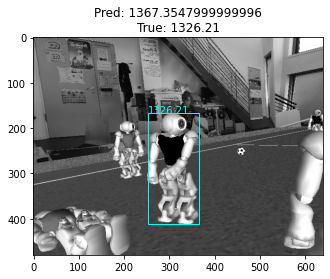

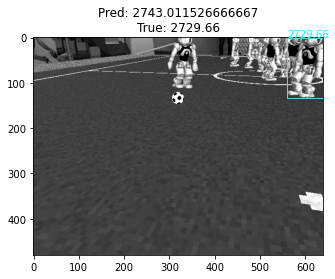

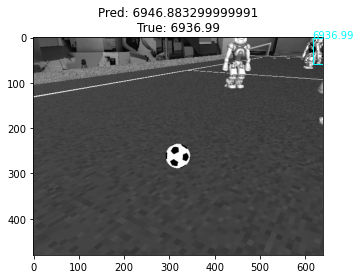

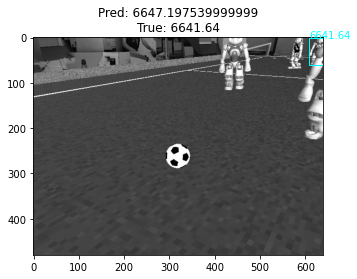

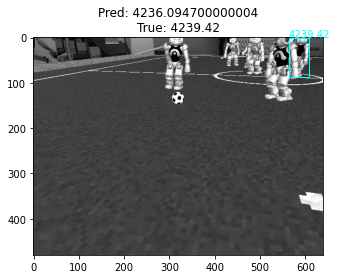

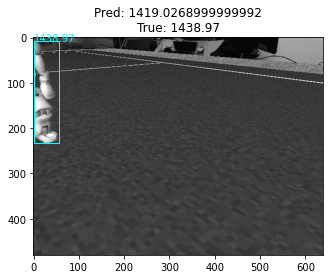

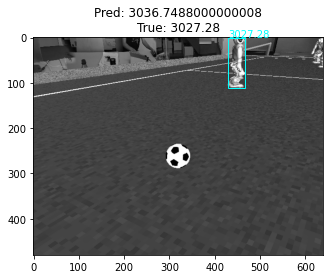

In [16]:
# Visualize Predicted Distances
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from skimage import io

def plot_img_with_bbox(img, bbox, pred_dis, true_dis):
    # Draw the image as a plot
    plt.imshow(img)

    # Label the image
    plt.title('Pred: ' + str(*pred_dis) + '\nTrue: ' + str(true_dis))
    # *tag[1:]
    x, y, xm, ym = bbox
    x *= 640
    xm *= 640
    y *= 480
    ym *= 480
    bbox = Rectangle((x, y), xm - x, ym - y, linewidth=1, edgecolor='cyan', facecolor='none')

    # Add bounding box with tag
    plt.gca().add_patch(bbox)
    plt.text(x, y, str(true_dis), color='cyan')

    plt.show()

def plot_by_ind(ind):
    test_offset = X_train.shape[0]

    filen = raw_data['name'][ind + test_offset]
    img = io.imread(PATH + 'images/' + filen)
    bbox = X_test.iloc[ind].values.tolist()

    pred_dis = forest_reg.predict(np.expand_dims(X_test.iloc[ind], axis=0))
    true_dis = y_test.iloc[ind]
    plot_img_with_bbox(img, bbox, pred_dis, true_dis)

for i in range(10):
    plot_by_ind(i)